#### 1. Preparing

In [333]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import opacus

In [334]:
data = pd.read_csv("./data/brain_stroke.csv")
data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


In [335]:
print((data['stroke']==1).sum())
print((data['stroke']==0).sum())

248
4733


In [336]:
data.dtypes

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [337]:
for column in data:
    print(f"{column} - {len(data[column].unique())} : {data[column].unique()}")

gender - 2 : ['Male' 'Female']
age - 104 : [6.70e+01 8.00e+01 4.90e+01 7.90e+01 8.10e+01 7.40e+01 6.90e+01 7.80e+01
 6.10e+01 5.40e+01 5.00e+01 6.40e+01 7.50e+01 6.00e+01 7.10e+01 5.20e+01
 8.20e+01 6.50e+01 5.70e+01 4.20e+01 4.80e+01 7.20e+01 5.80e+01 7.60e+01
 3.90e+01 7.70e+01 6.30e+01 7.30e+01 5.60e+01 4.50e+01 7.00e+01 5.90e+01
 6.60e+01 4.30e+01 6.80e+01 4.70e+01 5.30e+01 3.80e+01 5.50e+01 4.60e+01
 3.20e+01 5.10e+01 1.40e+01 3.00e+00 8.00e+00 3.70e+01 4.00e+01 3.50e+01
 2.00e+01 4.40e+01 2.50e+01 2.70e+01 2.30e+01 1.70e+01 1.30e+01 4.00e+00
 1.60e+01 2.20e+01 3.00e+01 2.90e+01 1.10e+01 2.10e+01 1.80e+01 3.30e+01
 2.40e+01 3.60e+01 6.40e-01 3.40e+01 4.10e+01 8.80e-01 5.00e+00 2.60e+01
 3.10e+01 7.00e+00 1.20e+01 6.20e+01 2.00e+00 9.00e+00 1.50e+01 2.80e+01
 1.00e+01 1.80e+00 3.20e-01 1.08e+00 1.90e+01 6.00e+00 1.16e+00 1.00e+00
 1.40e+00 1.72e+00 2.40e-01 1.64e+00 1.56e+00 7.20e-01 1.88e+00 1.24e+00
 8.00e-01 4.00e-01 8.00e-02 1.48e+00 5.60e-01 1.32e+00 1.60e-01 4.80e-01]
hyperte

In [338]:
dummies = pd.get_dummies(data, columns = ["work_type", "smoking_status"])
data = dummies
data.head()

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_Govt_job,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,Male,67.0,0,1,Yes,Urban,228.69,36.6,1,0,1,0,0,0,1,0,0
1,Male,80.0,0,1,Yes,Rural,105.92,32.5,1,0,1,0,0,0,0,1,0
2,Female,49.0,0,0,Yes,Urban,171.23,34.4,1,0,1,0,0,0,0,0,1
3,Female,79.0,1,0,Yes,Rural,174.12,24.0,1,0,0,1,0,0,0,1,0
4,Male,81.0,0,0,Yes,Urban,186.21,29.0,1,0,1,0,0,0,1,0,0


In [339]:
data.dtypes

gender                             object
age                               float64
hypertension                        int64
heart_disease                       int64
ever_married                       object
Residence_type                     object
avg_glucose_level                 float64
bmi                               float64
stroke                              int64
work_type_Govt_job                  uint8
work_type_Private                   uint8
work_type_Self-employed             uint8
work_type_children                  uint8
smoking_status_Unknown              uint8
smoking_status_formerly smoked      uint8
smoking_status_never smoked         uint8
smoking_status_smokes               uint8
dtype: object

In [340]:
data.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,work_type_Govt_job,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
count,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000
mean,43.419859,0.096165,0.055210,105.943562,28.498173,0.049789,0.129291,0.574182,0.161413,0.135113,0.301144,0.174061,0.369002,0.155792
std,22.662755,0.294848,0.228412,45.075373,6.790464,0.217531,0.335556,0.494516,0.367949,0.341879,0.458801,0.379200,0.482583,0.362694
min,0.080000,0.000000,0.000000,55.120000,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,0.000000,0.000000,77.230000,23.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,45.000000,0.000000,0.000000,91.850000,28.100000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,61.000000,0.000000,0.000000,113.860000,32.600000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,82.000000,1.000000,1.000000,271.740000,48.900000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [341]:
data.dropna(axis = 0, inplace = True)
data.isna().sum()

gender                            0
age                               0
hypertension                      0
heart_disease                     0
ever_married                      0
Residence_type                    0
avg_glucose_level                 0
bmi                               0
stroke                            0
work_type_Govt_job                0
work_type_Private                 0
work_type_Self-employed           0
work_type_children                0
smoking_status_Unknown            0
smoking_status_formerly smoked    0
smoking_status_never smoked       0
smoking_status_smokes             0
dtype: int64

In [342]:
data['gender']= data['gender'].map({'Male':1,'Female':0})
#data['work_type'], mapping = pd.factorize(data['work_type'])
data['ever_married'], mapping = pd.factorize(data['ever_married'])
#data['smoking_status'], mapping = pd.factorize(data['smoking_status'])
data['Residence_type'], mapping = pd.factorize(data['Residence_type'])
data.head()

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_Govt_job,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,1,67.0,0,1,0,0,228.69,36.6,1,0,1,0,0,0,1,0,0
1,1,80.0,0,1,0,1,105.92,32.5,1,0,1,0,0,0,0,1,0
2,0,49.0,0,0,0,0,171.23,34.4,1,0,1,0,0,0,0,0,1
3,0,79.0,1,0,0,1,174.12,24.0,1,0,0,1,0,0,0,1,0
4,1,81.0,0,0,0,0,186.21,29.0,1,0,1,0,0,0,1,0,0


In [343]:
data.dtypes

gender                              int64
age                               float64
hypertension                        int64
heart_disease                       int64
ever_married                        int64
Residence_type                      int64
avg_glucose_level                 float64
bmi                               float64
stroke                              int64
work_type_Govt_job                  uint8
work_type_Private                   uint8
work_type_Self-employed             uint8
work_type_children                  uint8
smoking_status_Unknown              uint8
smoking_status_formerly smoked      uint8
smoking_status_never smoked         uint8
smoking_status_smokes               uint8
dtype: object

In [344]:
data.corr()

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_Govt_job,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
gender,1.000000,-0.026538,0.021485,0.086476,0.028971,0.004301,0.055796,-0.012093,0.008870,-0.017176,-0.028706,-0.029635,0.090275,0.059858,0.045109,-0.102387,0.013349
age,-0.026538,1.000000,0.278120,0.264852,-0.677137,-0.017155,0.236763,0.373703,0.246478,0.126868,0.111020,0.326835,-0.636866,-0.379669,0.235508,0.122617,0.070899
hypertension,0.021485,0.278120,1.000000,0.111974,-0.164534,0.004755,0.170028,0.158762,0.131965,0.016378,-0.004177,0.110468,-0.128924,-0.139901,0.056797,0.065267,0.030749
heart_disease,0.086476,0.264852,0.111974,1.000000,-0.114765,-0.002125,0.166847,0.060926,0.134610,0.001166,-0.001600,0.087474,-0.092974,-0.066710,0.067541,-0.022727,0.044011
ever_married,0.028971,-0.677137,-0.164534,-0.114765,1.000000,0.008191,-0.150724,-0.371690,-0.108398,-0.133655,-0.146139,-0.191668,0.548851,0.335689,-0.172039,-0.104120,-0.106234
Residence_type,0.004301,-0.017155,0.004755,-0.002125,0.008191,1.000000,-0.001346,-0.013185,-0.016494,-0.013925,0.016104,-0.013427,0.004825,0.003937,-0.009825,0.026892,-0.030490
avg_glucose_level,0.055796,0.236763,0.170028,0.166847,-0.150724,-0.001346,1.000000,0.186348,0.133227,0.009223,0.020764,0.058419,-0.101960,-0.095504,0.066989,0.024727,0.017873
bmi,-0.012093,0.373703,0.158762,0.060926,-0.371690,-0.013185,0.186348,1.000000,0.056926,0.087375,0.211820,0.085582,-0.484257,-0.293912,0.120156,0.109322,0.100710
stroke,0.008870,0.246478,0.131965,0.134610,-0.108398,-0.016494,0.133227,0.056926,1.000000,0.002574,0.010459,0.062643,-0.085075,-0.055699,0.065320,-0.004806,0.008561
work_type_Govt_job,-0.017176,0.126868,0.016378,0.001166,-0.133655,-0.013925,0.009223,0.087375,0.002574,1.000000,-0.447467,-0.169061,-0.152306,-0.096437,0.029833,0.045091,0.030804


In [345]:
X = data.drop('stroke', axis=1)
y= data.stroke.values
num_samples, num_features=X.shape
print(num_samples, num_features)

4981 16


In [346]:
X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.2,random_state=42)

In [347]:
sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)

X_train=torch.from_numpy(X_train.astype(np.float32))
X_test=torch.from_numpy(X_test.astype(np.float32))
y_train=torch.from_numpy(y_train.astype(np.float32))
y_test=torch.from_numpy(y_test.astype(np.float32))

y_train=y_train.view(y_train.shape[0],1)
y_test=y_test.view(y_test.shape[0],1)


In [349]:
def evaluateModel(y_test,YResult):
    y_test = y_test.cpu().numpy()
    from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
    accuracy = accuracy_score(y_test, YResult)
    f1 = f1_score(y_test, YResult)
    recall = recall_score(y_test, YResult)
    precision = precision_score(y_test, YResult)
    print(f"Accuracy = {accuracy}")
    print(f"F1_score = {f1}")
    print(f"Recall = {recall}")
    print(f"Precision = {precision}")
    ReSult = {'Accuracy' : accuracy,'F1_score':f1,'Recall': recall,'Precision':precision}
    return ReSult 

In [350]:

class LogisticRegression(nn.Module):
    def __init__(self, n_input_features):
        super(LogisticRegression,self).__init__()
        self.linear=nn.Linear(n_input_features,1)
    
    def forward(self,x):
        y_predicted = torch.sigmoid(self.linear(x))
        return y_predicted
model=LogisticRegression(num_features)


def train_model(model, X_train, y_train, X_test, y_test, learning_rate=0.01, num_epochs=100):
    criterion = nn.BCELoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        y_predicted = model(X_train)
        loss = criterion(y_predicted, y_train)        
        loss.backward()        
        optimizer.step()    
        optimizer.zero_grad()
        if (epoch + 1) % 10 == 0:
            print(f"Epoch: {epoch + 1}, Loss: {loss.item():.4f}")
            
    with torch.no_grad():
        y_predicted = model(X_test)
        y_predicted_cls = y_predicted.round()
        accuracy = y_predicted_cls.eq(y_test).sum().item() / float(y_test.shape[0])
        print(f"Accuracy: {accuracy:.4f}")
        return y_predicted_cls,accuracy
        
num_trials = 100  # Số lần thử nghiệm
learning_rate_range = (0.001, 0.1)
num_epochs_range = (50, 200)

best_accuracy = 0
best_params = None
result_arr=[]

for _ in range(num_trials):
    modeltemp = LogisticRegression(num_features)
    learning_rate = np.random.uniform(*learning_rate_range)
    num_epochs = np.random.randint(*num_epochs_range)
    y_predicted_cls,accuracy = train_model(modeltemp, X_train, y_train, X_test, y_test, learning_rate, num_epochs)
    result_arr.append({'Accuracy': accuracy, 'Learning Rate': learning_rate, 'Num Epochs': num_epochs})
    if accuracy > 0.7 and accuracy < 0.9 and accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = {'Learning Rate': learning_rate, 'Num Epochs': num_epochs, 'Accuracy': best_accuracy}
        torch.save(model, './LogPredict.pth')



Epoch: 10, Loss: 0.5261
Epoch: 20, Loss: 0.4461
Epoch: 30, Loss: 0.3890
Epoch: 40, Loss: 0.3474
Epoch: 50, Loss: 0.3163
Epoch: 60, Loss: 0.2925
Epoch: 70, Loss: 0.2739
Epoch: 80, Loss: 0.2592
Epoch: 90, Loss: 0.2473
Epoch: 100, Loss: 0.2375
Epoch: 110, Loss: 0.2294
Epoch: 120, Loss: 0.2225
Accuracy: 0.9458
Epoch: 10, Loss: 0.5589
Epoch: 20, Loss: 0.4949
Epoch: 30, Loss: 0.4446
Epoch: 40, Loss: 0.4046
Epoch: 50, Loss: 0.3725
Epoch: 60, Loss: 0.3463
Epoch: 70, Loss: 0.3248
Accuracy: 0.9458
Epoch: 10, Loss: 0.5502
Epoch: 20, Loss: 0.4605
Epoch: 30, Loss: 0.3979
Epoch: 40, Loss: 0.3528
Epoch: 50, Loss: 0.3195
Epoch: 60, Loss: 0.2943
Epoch: 70, Loss: 0.2747
Epoch: 80, Loss: 0.2593
Epoch: 90, Loss: 0.2469
Epoch: 100, Loss: 0.2367
Epoch: 110, Loss: 0.2283
Epoch: 120, Loss: 0.2213
Epoch: 130, Loss: 0.2153
Accuracy: 0.9458
Epoch: 10, Loss: 0.7187
Epoch: 20, Loss: 0.6157
Epoch: 30, Loss: 0.5394
Epoch: 40, Loss: 0.4816
Epoch: 50, Loss: 0.4364
Epoch: 60, Loss: 0.4003
Epoch: 70, Loss: 0.3710
Epoch:

In [351]:
for result in result_arr:
    print(result)
if best_params != None:
    print(f"Best parameters found: Learning rate ={best_params['Learning Rate']}, Number of epochs ={best_params['Num Epochs']}, accuracy = {best_accuracy}")
    print("-------------------Train model with best parameter-------------------------------------")
    model.model = torch.load('./LogPredict.pth')
    YResult,AccResult=train_model(model,X_train,y_train,X_test,y_test,best_params['Learning Rate'],best_params['Num Epochs'])
else:
    print("-------------------Train model without best parameter-------------------------------------")
    YResult,AccResult=train_model(model, X_train, y_train, X_test, y_test)

{'Accuracy': 0.9458375125376128, 'Learning Rate': 0.07428739298153496, 'Num Epochs': 127}
{'Accuracy': 0.9458375125376128, 'Learning Rate': 0.050664355329694766, 'Num Epochs': 71}
{'Accuracy': 0.9458375125376128, 'Learning Rate': 0.07618138996815456, 'Num Epochs': 138}
{'Accuracy': 0.9458375125376128, 'Learning Rate': 0.04516910165688493, 'Num Epochs': 152}
{'Accuracy': 0.9458375125376128, 'Learning Rate': 0.0853724205815793, 'Num Epochs': 112}
{'Accuracy': 0.7903711133400201, 'Learning Rate': 0.007768723081375184, 'Num Epochs': 115}
{'Accuracy': 0.9458375125376128, 'Learning Rate': 0.048392234261510896, 'Num Epochs': 79}
{'Accuracy': 0.9458375125376128, 'Learning Rate': 0.03797998027762478, 'Num Epochs': 136}
{'Accuracy': 0.9458375125376128, 'Learning Rate': 0.07726996675537222, 'Num Epochs': 56}
{'Accuracy': 0.9458375125376128, 'Learning Rate': 0.029239166532513915, 'Num Epochs': 60}
{'Accuracy': 0.9458375125376128, 'Learning Rate': 0.0861382400830875, 'Num Epochs': 146}
{'Accuracy':

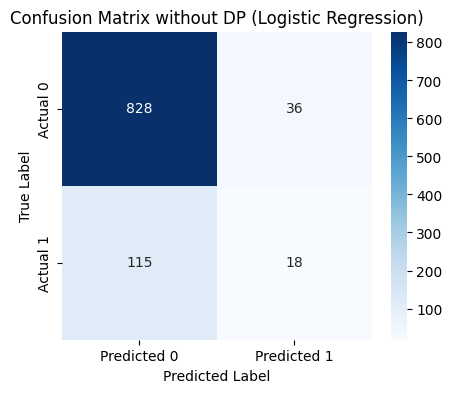

In [352]:
# Tạo ma trận nhầm lẫn
cm = confusion_matrix(YResult, y_test)

# Tạo heatmap từ ma trận nhầm lẫn
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix without DP (Logistic Regression)')
plt.savefig('../static/app/images/ConfusionMatrixLogBefore.JPG')
plt.show()

In [353]:
# Chuyển đổi kết quả dự đoán thành numpy array để sử dụng với các hàm tính toán từ sklearn.metrics
YResult1 = YResult.cpu().numpy()
logResult=evaluateModel(y_test,YResult1)


Accuracy = 0.8485456369107321
F1_score = 0.1925133689839572
Recall = 0.3333333333333333
Precision = 0.13533834586466165


In [354]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
class DecisionTreeModel:
    def __init__(self, x_train, y_train, max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=None, criterion="entropy"):
        self.x_train = x_train
        self.y_train = y_train
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.random_state = random_state
        self.criterion = criterion
        self.model = None

    def train(self):
        self._train_with_random_search()
    def _train_with_random_search(self):
        param_dist = {
            'max_depth': [2, 3, 5, 7,9,10],
            'min_samples_leaf': [5, 10, 20, 50, 100],
            'criterion': ["gini", "entropy"],
            'min_samples_split': [2,4, 5,6, 10],
            'random_state': [42, 88, 123]
        }

        dt_classifier = DecisionTreeClassifier()

        random_search = RandomizedSearchCV(
            dt_classifier, param_distributions=param_dist, n_iter=50, cv=3, scoring='accuracy', random_state=self.random_state)

        random_search.fit(self.x_train, self.y_train)

        self.model = random_search.best_estimator_
        # In ra thông tin về siêu tham số tốt nhất
        print("Best Parameters:", random_search.best_params_)


    def predict(self, x_test):
        return self.model.predict(x_test)

    def get_model(self):
        return self.model

    def set_model(self, model):
        self.model = model

    def get_model_parameters(self):
        return self.model.get_params()

    def evaluate(self, x_test, y_test):
        from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
        y_pred = self.predict(x_test)
        print("Accuracy:", accuracy_score(y_test, y_pred))
        print("Classification Report:", classification_report(y_test, y_pred))
        # Tạo ma trận nhầm lẫn
        cm = confusion_matrix(y_test, y_pred)
        # Tạo heatmap từ ma trận nhầm lẫn
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix (Decision Tree)')
        plt.savefig('../static/app/images/ConfusionMatrixDec.JPG')
        plt.show()
        return y_pred

Best Parameters: {'random_state': 42, 'min_samples_split': 5, 'min_samples_leaf': 50, 'max_depth': 9, 'criterion': 'gini'}
Accuracy: 0.9458375125376128
Classification Report:               precision    recall  f1-score   support

         0.0       0.95      1.00      0.97       943
         1.0       0.00      0.00      0.00        54

    accuracy                           0.95       997
   macro avg       0.47      0.50      0.49       997
weighted avg       0.89      0.95      0.92       997



c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

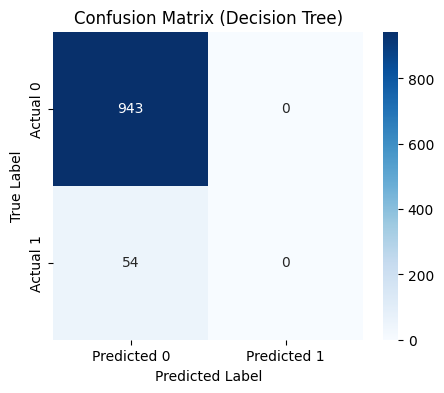

Accuracy = 0.9458375125376128
F1_score = 0.0
Recall = 0.0
Precision = 0.0


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [355]:
modelDec = DecisionTreeModel(X_train,y_train)
modelDec.train()
yResultDes=modelDec.evaluate(X_test,y_test)
DesResult=evaluateModel(y_test,yResultDes)

In [356]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

class RandomForestModel:
    def __init__(self, n_estimators=100, max_depth=None, random_state=None):
        self.model = RandomForestClassifier(n_estimators=n_estimators,
                                            max_depth=max_depth,
                                            random_state=random_state)
        self.is_trained = False

    def train(self, X_train, y_train):
        self.model.fit(X_train, y_train)
        self.is_trained = True

    def predict(self, X_test):
        if not self.is_trained:
            raise ValueError("Model has not been trained yet. Please train the model before making predictions.")
        return self.model.predict(X_test)

    def evaluate(self, X_test, y_test):
        if not self.is_trained:
            raise ValueError("Model has not been trained yet. Please train the model before evaluation.")
        y_pred = self.predict(X_test)
        print("Accuracy:", accuracy_score(y_test, y_pred))
        # Tạo ma trận nhầm lẫn
        cm = confusion_matrix(y_test, y_pred)
        # Tạo heatmap từ ma trận nhầm lẫn
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix (Randomforest)')
        plt.savefig('../static/app/images/ConfusionMatrixRand.JPG')
        plt.show()
        return y_pred

    def get_feature_importance(self):
        if not self.is_trained:
            raise ValueError("Model has not been trained yet. Please train the model before getting feature importances.")
        return self.model.feature_importances_
    
    def random_search(self, X_train, y_train, param_dist, cv=5, n_iter=50, random_state=42):
        random_search = RandomizedSearchCV(self.model, param_dist, cv=cv, n_iter=n_iter, random_state=random_state)
        random_search.fit(X_train, y_train)
        self.model = random_search.best_estimator_
        self.is_trained = True

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 12 is smaller than n_iter=50. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Accuracy: 0.9408224674022067


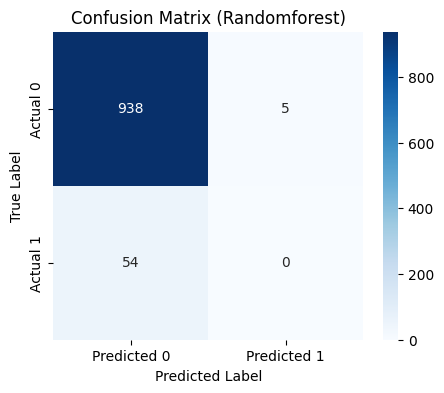

Accuracy = 0.9408224674022067
F1_score = 0.0
Recall = 0.0
Precision = 0.0


In [357]:
param_dist = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30]
}
modelRand = RandomForestModel()
modelRand.random_search(X_train, y_train.ravel(), param_dist)
yResultRand= modelRand.evaluate(X_test,y_test.ravel())
RandResult = evaluateModel(y_test,yResultRand)

In [358]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report

class NaiveBayesModel:
    def __init__(self):
        self.model = GaussianNB()
        self.is_trained = False

    def train(self, X_train, y_train):
        self.model.fit(X_train, y_train)
        self.is_trained = True

    def predict(self, X_test):
        if not self.is_trained:
            raise ValueError("Model has not been trained yet. Please train the model before making predictions.")
        return self.model.predict(X_test)

    def evaluate(self, X_test, y_test):
        if not self.is_trained:
            raise ValueError("Model has not been trained yet. Please train the model before evaluation.")

        y_pred = self.predict(X_test)
        print("Accuracy:", accuracy_score(y_test, y_pred))
        print("Classification Report:", classification_report(y_test, y_pred))
        # Tạo ma trận nhầm lẫn
        cm = confusion_matrix(y_test, y_pred)
        # Tạo heatmap từ ma trận nhầm lẫn
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix (Naive)')
        plt.savefig('../static/app/images/ConfusionMatrixNaive.JPG')
        plt.show()
        return y_pred

Accuracy: 0.7903711133400201
Classification Report:               precision    recall  f1-score   support

         0.0       0.98      0.80      0.88       943
         1.0       0.16      0.67      0.26        54

    accuracy                           0.79       997
   macro avg       0.57      0.73      0.57       997
weighted avg       0.93      0.79      0.84       997



c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


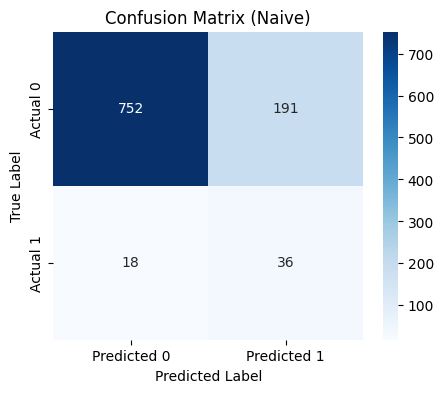

Accuracy = 0.7903711133400201
F1_score = 0.25622775800711745
Recall = 0.6666666666666666
Precision = 0.15859030837004406


In [359]:
modelNaive = NaiveBayesModel()
modelNaive.train(X_train,y_train)
yResultNaive = modelNaive.evaluate(X_test,y_test)
NaiveResult = evaluateModel(y_test,yResultNaive)

In [360]:
class LogisticRegressionDP:
    def __init__(self,model,X_train,y_train, X_test, y_test, EPSILON = 1.0,DELTA = 1e-5, EPOCHS = 10, MAX_GRAD_NORM = 0.1, MAX_PHYSICAL_BATCH_SIZE = 256, LOGGING_INTERVAL = 100,learning_rate=0.01, num_epochs=100):
        self.EPSILON=EPSILON
        self.DELTA=DELTA
        self.EPOCHS=EPOCHS
        self.MAX_GRAD_NORM=MAX_GRAD_NORM
        self.MAX_PHYSICAL_BATCH_SIZE = MAX_PHYSICAL_BATCH_SIZE
        self.LOGGING_INTERVAL=LOGGING_INTERVAL
        self.X_train=X_train
        self.y_train=y_train
        self.X_test=X_test
        self.y_test=y_test
        self.learning_rate=learning_rate
        self.model=model
        self.num_epochs=num_epochs
        self.device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.status=False
    def preTrain(self):
        train_dataset = TensorDataset(self.X_train, self.y_train)
        train_dataloader = DataLoader(train_dataset, batch_size=self.MAX_PHYSICAL_BATCH_SIZE, shuffle=True)
        model = self.model.to(self.device)
        criterion = nn.BCELoss()
        optimizer = torch.optim.SGD(model.parameters(),lr=self.learning_rate)
        model = model.train()
        return train_dataloader,model,optimizer,criterion
    def train_model(self):
        from opacus import PrivacyEngine
        
        privacy_engine = PrivacyEngine()
        train_dataloader,model,optimizer,criterion= self.preTrain()
        model, optimizer, data_loader = privacy_engine.make_private_with_epsilon(
            module=model,
            optimizer=optimizer,
            data_loader=train_dataloader,
            target_delta=self.DELTA,
            target_epsilon=self.EPSILON, 
            epochs=self.EPOCHS,
            max_grad_norm=self.MAX_GRAD_NORM,
        )
        print(f"Training with hyperparameters:")
        print(f"  EPSILON: {self.EPSILON}")
        print(f"  DELTA: {self.DELTA}")
        print(f"  EPOCHS: {self.EPOCHS}")
        print(f"  MAX_GRAD_NORM: {self.MAX_GRAD_NORM}")
        print(f"  MAX_PHYSICAL_BATCH_SIZE: {self.MAX_PHYSICAL_BATCH_SIZE}")
        print(f"  LOGGING_INTERVAL: {self.LOGGING_INTERVAL}")
        print(f"  learning_rate: {self.learning_rate}")
        print(f"  num_epochs: {self.num_epochs}")
        num_epochs = self.num_epochs
        losses = []  # Danh sách lưu giữ giá trị loss
        epsilons = []  # Danh sách lưu giữ giá trị epsilon

        for epoch in range(num_epochs):
            for step,(X_batch, y_batch) in enumerate(data_loader):
                X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)
                y_predicted = model(X_batch)
                loss = criterion(y_predicted,y_batch)
                
                loss.backward()
                
                optimizer.step()
                
                optimizer.zero_grad()
                
                if step >= 0 and step % self.LOGGING_INTERVAL == 0:
                    eps = privacy_engine.get_epsilon(self.DELTA)
                    if(epoch+1) % 10 ==0:
                        print(f"epoch: {epoch+1}, loss={loss.item():.4f}  | ɛ: {eps:.2f} ")
                        
                    losses.append(loss.item())
                    epsilons.append(eps)
        with torch.no_grad():
            y_predicted = model(self.X_test.to(self.device))
            y_predicted_cls = y_predicted.round()
            acc = y_predicted_cls.eq(self.y_test.to(self.device)).sum() / float(self.y_test.to(self.device).shape[0])
            print(f"accuracy = {acc:.4f}")
        if self.status == True:
            torch.save(model, './StruckPredict.pth')
        epochs = range(1, num_epochs + 1)
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.plot(epochs, losses, label='Loss', marker='o')
        plt.title('Loss Over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(epochs, epsilons, label='Epsilon', marker='o')
        plt.title('Epsilon Over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Epsilon')
        plt.legend()

        plt.tight_layout()
        plt.savefig('../static/app/images/epsilonAndLoss.JPG')
        plt.show()
        return acc
    def predict_model(self, X):
        with torch.no_grad():
            y_predicted = self.model(X.to(self.device))
            y_predicted_cls = y_predicted.round()
            return y_predicted_cls
    def train_model_for_grid(self):
        from opacus import PrivacyEngine
        
        privacy_engine = PrivacyEngine()
        train_dataloader,model,optimizer,criterion= self.preTrain()
        model, optimizer, data_loader = privacy_engine.make_private_with_epsilon(
            module=model,
            optimizer=optimizer,
            data_loader=train_dataloader,
            target_delta=self.DELTA,
            target_epsilon=self.EPSILON, 
            epochs=self.EPOCHS,
            max_grad_norm=self.MAX_GRAD_NORM,
        )
        num_epochs = self.num_epochs
        for epoch in range(num_epochs):
            for step,(X_batch, y_batch) in enumerate(data_loader):
                X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)
                y_predicted = model(X_batch)
                loss = criterion(y_predicted,y_batch)
                
                loss.backward()
                
                optimizer.step()
                
                optimizer.zero_grad()
        with torch.no_grad():
            y_predicted = model(self.X_test.to(self.device))
            y_predicted_cls = y_predicted.round()
            acc = y_predicted_cls.eq(self.y_test.to(self.device)).sum() / float(self.y_test.to(self.device).shape[0])
        return acc
    def grid_search(self,num_features):
        from sklearn.model_selection import ParameterGrid
        best_accuracy = 0
        best_params = None
        param_grid = {
        'EPSILON': [1.0, 0.5],
        'DELTA': [1e-5, 1e-6],
        'EPOCHS': [10, 20],
        'MAX_GRAD_NORM': [0.1, 0.2],
        'MAX_PHYSICAL_BATCH_SIZE': [256, 512],
        'LOGGING_INTERVAL': [100, 200],
        'learning_rate': [0.01, 0.001],
        'num_epochs': [50, 100]
        }
        all_params = list(ParameterGrid(param_grid))
        total_combinations = len(all_params)

        for i, params in enumerate(all_params, 1):
            print(f"Training model {i}/{total_combinations} with parameters: {params}")
            modelTemp=LogisticRegression(num_features)
            logDPTemp=LogisticRegressionDP(modelTemp,X_train,y_train,X_test,y_test,params['EPSILON'],params['DELTA'],params['EPOCHS'],params['MAX_GRAD_NORM'],params['MAX_PHYSICAL_BATCH_SIZE'],params['LOGGING_INTERVAL'],params['learning_rate'],params['num_epochs'],)
            acc = logDPTemp.train_model_for_grid()
            print(f"Accuracy: {acc:.4f}\n")

            if acc > 0.7 and acc < 0.9:
                if acc > best_accuracy:
                    best_accuracy = acc
                    best_params = params
        if best_params != None:
            print("Grid search finished.")
            print(f"Best accuracy: {best_accuracy:.4f}")
            print("Best parameters:", best_params)
            self.update_parameters(best_params)
    
    def update_parameters(self, new_params):
        # Update the model parameters with the new_params
        self.EPSILON = new_params['EPSILON']
        self.DELTA = new_params['DELTA']
        self.EPOCHS = new_params['EPOCHS']
        self.MAX_GRAD_NORM = new_params['MAX_GRAD_NORM']
        self.MAX_PHYSICAL_BATCH_SIZE = new_params['MAX_PHYSICAL_BATCH_SIZE']
        self.LOGGING_INTERVAL = new_params['LOGGING_INTERVAL']
        self.learning_rate = new_params['learning_rate']
        self.num_epochs = new_params['num_epochs']
        self.status=True

In [361]:
model2=LogisticRegression(num_features)
logDP=LogisticRegressionDP(model2,X_train,y_train,X_test,y_test)
#logDP.train_model()

In [362]:
logDP.grid_search(num_features)

Training model 1/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 10, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.01, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

Accuracy: 0.4935

Training model 2/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 10, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.01, 'num_epochs': 100}
Accuracy: 0.5858

Training model 3/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 10, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.001, 'num_epochs': 50}
Accuracy: 0.5246

Training model 4/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 10, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.001, 'num_epochs': 100}
Accuracy: 0.5908

Training model 5/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 10, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.01, 'num_epochs': 50}
Accuracy: 0.5206

Training model 6/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 10, 'EPSILON': 1.0, '

Training with hyperparameters:
  EPSILON: 0.5
  DELTA: 1e-05
  EPOCHS: 20
  MAX_GRAD_NORM: 0.2
  MAX_PHYSICAL_BATCH_SIZE: 256
  LOGGING_INTERVAL: 200
  learning_rate: 0.01
  num_epochs: 100
epoch: 10, loss=0.7910  | ɛ: 0.33 
epoch: 20, loss=0.7698  | ɛ: 0.48 
epoch: 30, loss=0.7207  | ɛ: 0.60 
epoch: 40, loss=0.6727  | ɛ: 0.71 
epoch: 50, loss=0.6956  | ɛ: 0.80 
epoch: 60, loss=0.6244  | ɛ: 0.88 
epoch: 70, loss=0.6077  | ɛ: 0.96 
epoch: 80, loss=0.5500  | ɛ: 1.03 
epoch: 90, loss=0.5501  | ɛ: 1.10 
epoch: 100, loss=0.5317  | ɛ: 1.17 
accuracy = 0.7723


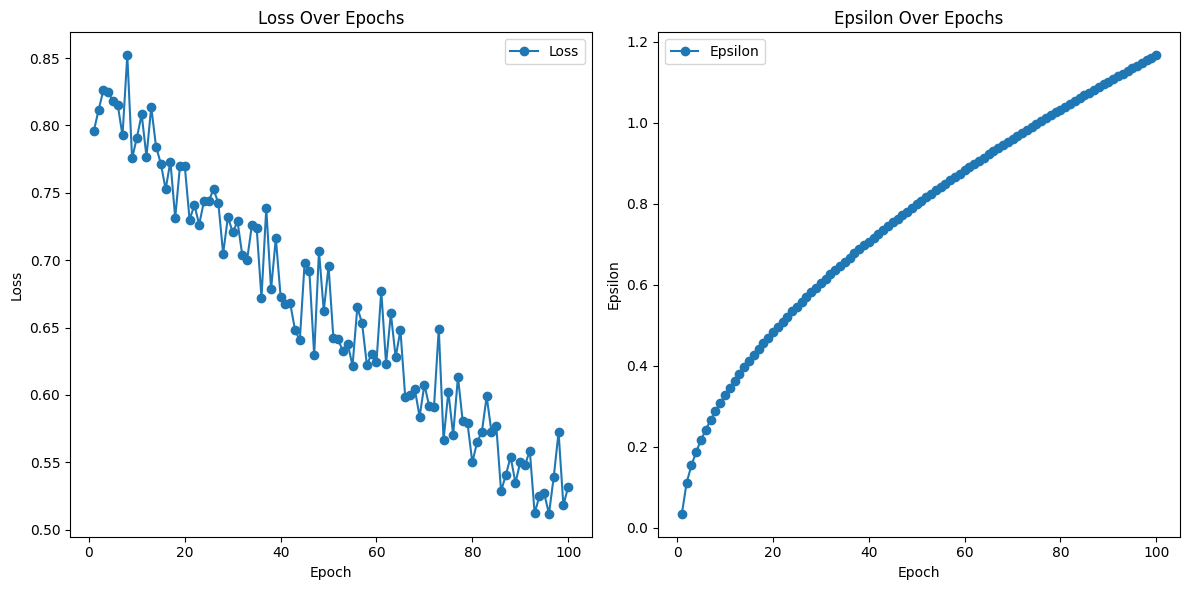

In [363]:
logDP.train_model()
y_predicted_cls=logDP.predict_model(X_test)

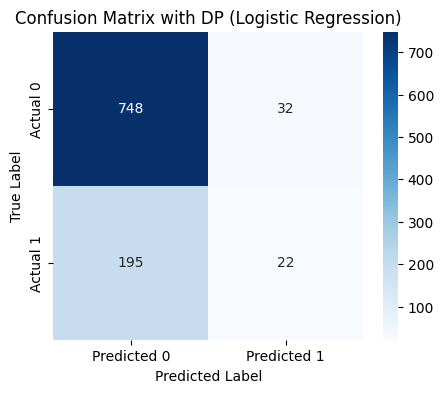

In [364]:
# Tạo ma trận nhầm lẫn
cm = confusion_matrix(y_predicted_cls.cpu(), y_test)

# Tạo heatmap từ ma trận nhầm lẫn
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix with DP (Logistic Regression)')
plt.savefig('../static/app/images/ConfusionMatrixLogAfter.JPG')
plt.show()

In [365]:
model = LogisticRegression(num_features)  
dp_model = LogisticRegressionDP(model, X_train, y_train, X_test, y_test, ...)
dp_model.model = torch.load('./StruckPredict.pth')
prediction = dp_model.predict_model(torch.tensor(X_test))

C:\Users\Admin\AppData\Local\Temp\ipykernel_16244\949358160.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  prediction = dp_model.predict_model(torch.tensor(X_test))


In [366]:
logResultDP= evaluateModel(y_test,prediction.cpu())

Accuracy = 0.7723169508525577
F1_score = 0.16236162361623616
Recall = 0.4074074074074074
Precision = 0.10138248847926268


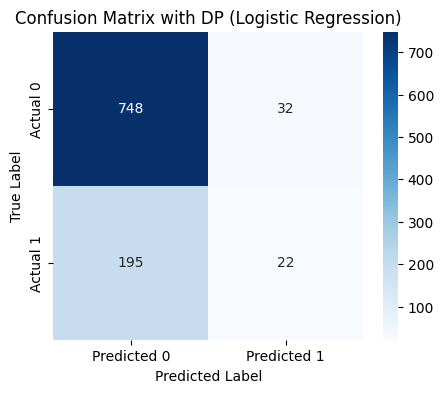

In [367]:
# Tạo ma trận nhầm lẫn
cm = confusion_matrix(prediction.cpu(), y_test)

# Tạo heatmap từ ma trận nhầm lẫn
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix with DP (Logistic Regression)')
plt.savefig('../static/app/images/ConfusionMatrixLogAfter.JPG')
plt.show()

<Figure size 30000x2000 with 0 Axes>

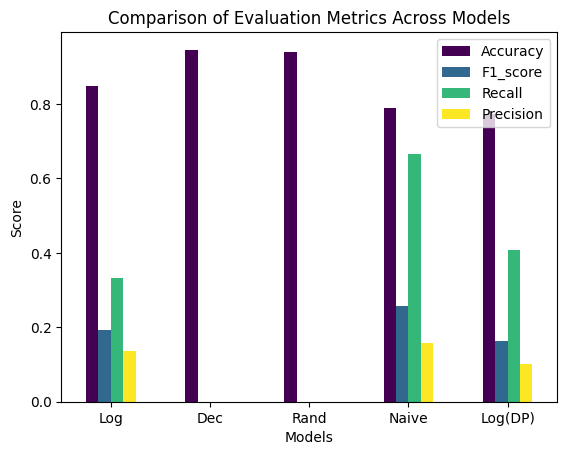

In [368]:
import matplotlib.pyplot as plt
import seaborn as sns

# Đặt tên cho các model (có thể là tên của các biến chứa kết quả)
model_names = ['Log', 'Dec', 'Rand', 'Naive', 'Log(DP)']

# Kết quả của hàm evaluateModel cho từng model
results = [
    logResult,DesResult,RandResult,NaiveResult,logResultDP
]

# Tạo DataFrame từ kết quả
df_results = pd.DataFrame(results, index=model_names)

# Vẽ biểu đồ
plt.figure(figsize=(300, 20))
df_results.plot(kind='bar', rot=0, colormap='viridis', width=0.5)
plt.title('Comparison of Evaluation Metrics Across Models')
plt.xlabel('Models')
plt.ylabel('Score')
plt.savefig("../static/app/images/ModelScore.jpg")
plt.show()

In [369]:
from tabulate import tabulate
table = tabulate(df_results, headers='keys', tablefmt='pretty', showindex=True)
print(table)

+---------+--------------------+---------------------+--------------------+---------------------+
|         |      Accuracy      |      F1_score       |       Recall       |      Precision      |
+---------+--------------------+---------------------+--------------------+---------------------+
|   Log   | 0.8485456369107321 | 0.1925133689839572  | 0.3333333333333333 | 0.13533834586466165 |
|   Dec   | 0.9458375125376128 |         0.0         |        0.0         |         0.0         |
|  Rand   | 0.9408224674022067 |         0.0         |        0.0         |         0.0         |
|  Naive  | 0.7903711133400201 | 0.25622775800711745 | 0.6666666666666666 | 0.15859030837004406 |
| Log(DP) | 0.7723169508525577 | 0.16236162361623616 | 0.4074074074074074 | 0.10138248847926268 |
+---------+--------------------+---------------------+--------------------+---------------------+


In [372]:
data_single_person = {
    'gender': [1],
    'age': [30],
    'hypertension': [0],
    'heart_disease': [0],
    'ever_married': [1],
    'Residence_type': [1],
    'avg_glucose_level': [330],
    'bmi': [30.0],
    'work_type_Govt_job': [0],
    'work_type_Private': [1],
    'work_type_Self-employed': [0],
    'work_type_children': [0],
    'smoking_status_Unknown': [0],
    'smoking_status_formerly smoked': [0],
    'smoking_status_never smoked': [0],
    'smoking_status_smokes': [1]
}

df_single_person = pd.DataFrame(data_single_person)
df_single_person=sc.transform(df_single_person)
df_single_person=torch.from_numpy(df_single_person.astype(np.float32))
prediction2 = dp_model.predict_model(torch.tensor(df_single_person))

C:\Users\Admin\AppData\Local\Temp\ipykernel_16244\2140165275.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  prediction2 = dp_model.predict_model(torch.tensor(df_single_person))


In [373]:
print(prediction2.item())

0.0
